In [0]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
!ls
!ls "/gdrive/My Drive/Colab Notebooks/"

sample_data
1_oneClass_classification.ipynb    dataset.zip
2_multiClass_classification.ipynb  multi-trash.zip


In [0]:
import zipfile as zf
files = zf.ZipFile("/gdrive/My Drive/Colab Notebooks/dataset.zip",'r')
files.extractall()
files.close()

In [0]:
!ls

dataset  sample_data


In [0]:
import os
os.listdir(os.path.join(os.getcwd(), "dataset"))

['trash', 'glass', 'paper', 'cardboard', 'metal', 'plastic']

In [0]:
from pathlib import Path
path = Path(os.getcwd())/"dataset"
path

PosixPath('/content/dataset')

In [0]:
# train, valid, test 구조로 분할하는 함수
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    # train 인덱싱
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)), int(.5*n)) # 50%를 train 폴더로 이동
    remain = list(set(full_set)-set(train))

    # valid 인덱싱
    random.seed(seed2)
    valid = random.sample(remain, int(.5*len(remain))) # 남은 것들 중 50%(전체 25%)를 valid 폴더로 이동
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

# 인덱싱에 따라 파일 이름을 구하기
def get_names(waste_type, indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)

# 파일의 위치를 옮기는 함수
def move_files(source_files, destination_folder):
    for file in source_files:
        shutil.move(file, destination_folder)

In [0]:
import random
import shutil

# 데이터 종류 / 쓰레기 타입 설정
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

# data/데이터 종류/쓰레기 타입 디렉토리가 존재하지 않으면 폴더를 생성한다.
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data', subset, waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)

# test 폴더는 쓰레기 타입 디렉토리가 포함되지 않으므로 따로 작성
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
# 각 쓰레기 타입별로 
for waste_type in waste_types:
    source_folder = os.path.join('dataset', waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    # 파일들을 train 폴더로 옮김
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    move_files(train_source_files, "data/train/" + waste_type)
    
    # 파일들을 valid 폴더로 옮김
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    move_files(valid_source_files, "data/valid/" + waste_type)
    
    # 파일들을 test폴더로 옮김
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    move_files(test_source_files,"data/test")    # test 폴더는 쓰레기 타입 미포함

In [0]:
# 변경된 디렉토리 구조 확인
!ls
!ls data

data  dataset  sample_data
test  train  valid


In [0]:
from fastai.vision import *

path = Path(os.getcwd())/"data"
tfms = get_transforms(do_flip=True, flip_vert=True)
data = ImageDataBunch.from_folder(path, test="test", ds_tfms=tfms, bs=16)
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
trash,trash,trash,trash,trash
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
trash,trash,trash,trash,trash
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [0]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

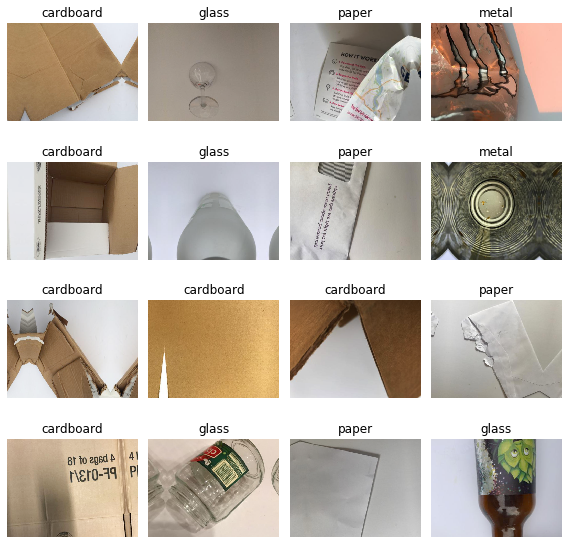

In [0]:
data.show_batch(rows=4, figsize=(8,8))

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
# learn.model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:06<00:00, 13.6MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.77E-03
Min loss divided by 10: 2.19E-03


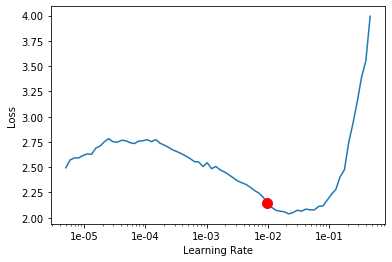

In [0]:
learn.lr_find(start_lr=1e-6, end_lr=1e1)
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(20, max_lr=9.77E-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.262207,0.637584,0.231746,00:30
1,0.919786,0.602011,0.188889,00:30
2,0.934117,0.614367,0.179365,00:30
3,0.993572,0.994304,0.285714,00:30
4,1.087418,1.196850,0.323810,00:30
5,1.247416,1.166708,0.336508,00:29
6,1.100190,0.549601,0.198413,00:29
7,0.907709,0.516884,0.177778,00:29
8,0.830426,0.445439,0.157143,00:29
9,0.738388,0.426004,0.141270,00:29


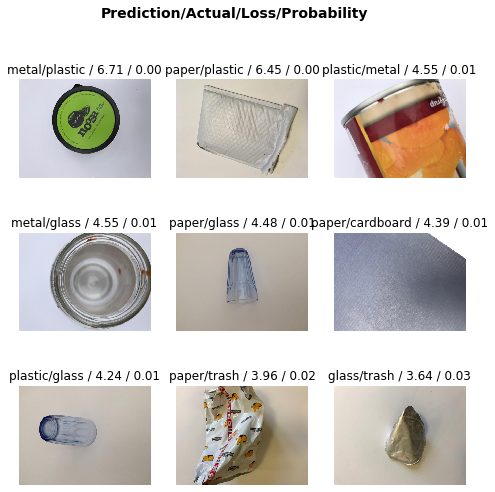

In [0]:
# loss 값이 큰 것들 순서대로
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(8,8))

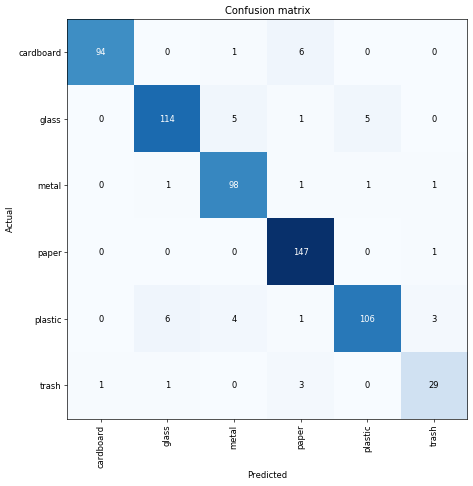

In [0]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [0]:
# 가장 혼동되는 조합 정렬
interp.most_confused()

[('cardboard', 'paper', 6),
 ('plastic', 'glass', 6),
 ('glass', 'metal', 5),
 ('glass', 'plastic', 5),
 ('plastic', 'metal', 4),
 ('plastic', 'trash', 3),
 ('trash', 'paper', 3),
 ('cardboard', 'metal', 1),
 ('glass', 'paper', 1),
 ('metal', 'glass', 1),
 ('metal', 'paper', 1),
 ('metal', 'plastic', 1),
 ('metal', 'trash', 1),
 ('paper', 'trash', 1),
 ('plastic', 'paper', 1),
 ('trash', 'cardboard', 1),
 ('trash', 'glass', 1)]

# **2. 테스트 데이터**

In [0]:
preds = learn.get_preds(ds_type=DatasetType.Test)
print(preds[0].shape)
print(preds[0])

torch.Size([635, 6])
tensor([[3.9000e-03, 2.9650e-01, 2.6574e-01, 2.0607e-02, 4.1257e-01, 6.8659e-04],
        [9.4355e-04, 2.8373e-06, 1.9384e-07, 9.9859e-01, 2.5730e-04, 2.0141e-04],
        [3.9116e-05, 2.9315e-07, 3.0918e-06, 9.9978e-01, 1.0735e-04, 6.6944e-05],
        ...,
        [1.8661e-03, 4.6979e-01, 1.2746e-02, 1.8262e-03, 5.1174e-01, 2.0311e-03],
        [9.9995e-01, 4.8757e-07, 2.1705e-06, 5.7252e-06, 2.4476e-05, 1.4907e-05],
        [9.4885e-05, 1.7801e-06, 3.7941e-05, 9.9667e-01, 2.4912e-03, 7.0254e-04]])


In [0]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [0]:
# 각 이미지에 예측된 class의 번호를 부여
max_idxs = np.asarray(np.argmax(preds[0],axis=1))
max_idxs

array([4, 3, 3, 4, ..., 1, 4, 0, 3])

In [0]:
# 부여된 번호를 토대로 class의 이름을 부여
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])
print(yhat)

['plastic', 'paper', 'paper', 'plastic', 'paper', 'cardboard', 'glass', 'trash', 'glass', 'paper', 'metal', 'cardboard', 'plastic', 'paper', 'paper', 'metal', 'plastic', 'paper', 'paper', 'cardboard', 'plastic', 'cardboard', 'cardboard', 'plastic', 'paper', 'plastic', 'plastic', 'paper', 'paper', 'paper', 'plastic', 'glass', 'glass', 'paper', 'metal', 'metal', 'trash', 'plastic', 'metal', 'trash', 'glass', 'cardboard', 'trash', 'metal', 'paper', 'paper', 'trash', 'metal', 'metal', 'plastic', 'metal', 'glass', 'plastic', 'cardboard', 'paper', 'cardboard', 'paper', 'metal', 'paper', 'trash', 'metal', 'glass', 'metal', 'cardboard', 'metal', 'cardboard', 'glass', 'glass', 'trash', 'plastic', 'metal', 'paper', 'metal', 'cardboard', 'glass', 'paper', 'metal', 'metal', 'paper', 'metal', 'glass', 'glass', 'cardboard', 'metal', 'metal', 'cardboard', 'paper', 'metal', 'paper', 'metal', 'metal', 'paper', 'cardboard', 'cardboard', 'metal', 'plastic', 'metal', 'paper', 'paper', 'glass', 'glass', 'c

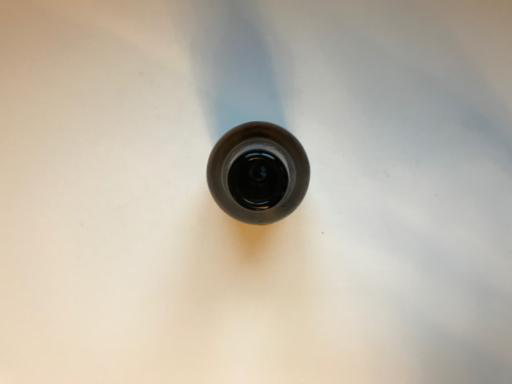

In [0]:
# 첫번째 test 데이터의 이미지 확인
learn.data.test_ds[0][0]

In [0]:
y = []
# 각 이미지 파일의 경로를 저장
for label_path in data.test_ds.items:
    y.append(str(label_path))

# 파일 이름을 통해 정답값을 추출.
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

print(y)

['glass', 'paper', 'paper', 'plastic', 'paper', 'cardboard', 'glass', 'trash', 'glass', 'paper', 'metal', 'cardboard', 'plastic', 'paper', 'paper', 'metal', 'plastic', 'paper', 'paper', 'cardboard', 'plastic', 'cardboard', 'cardboard', 'plastic', 'paper', 'plastic', 'plastic', 'paper', 'paper', 'paper', 'plastic', 'metal', 'plastic', 'paper', 'metal', 'metal', 'paper', 'plastic', 'metal', 'trash', 'glass', 'cardboard', 'trash', 'metal', 'cardboard', 'paper', 'trash', 'metal', 'metal', 'plastic', 'cardboard', 'glass', 'plastic', 'cardboard', 'paper', 'cardboard', 'paper', 'metal', 'paper', 'trash', 'metal', 'glass', 'metal', 'cardboard', 'metal', 'cardboard', 'glass', 'glass', 'trash', 'plastic', 'glass', 'paper', 'metal', 'cardboard', 'glass', 'paper', 'metal', 'metal', 'paper', 'metal', 'glass', 'glass', 'cardboard', 'metal', 'metal', 'cardboard', 'paper', 'metal', 'paper', 'metal', 'metal', 'trash', 'cardboard', 'metal', 'metal', 'plastic', 'metal', 'paper', 'paper', 'glass', 'glass'

In [0]:
# 예측값
print(yhat[0:5])
# 실제값
print(y[0:5])

['plastic', 'paper', 'paper', 'plastic', 'paper']
['glass', 'paper', 'paper', 'plastic', 'paper']


[[ 94   1   2   4   0   0]
 [  0 112   8   0   6   0]
 [  1   8  93   0   0   1]
 [  0   0   1 145   1   2]
 [  0   4   0   1 113   3]
 [  0   0   0   2   5  28]]


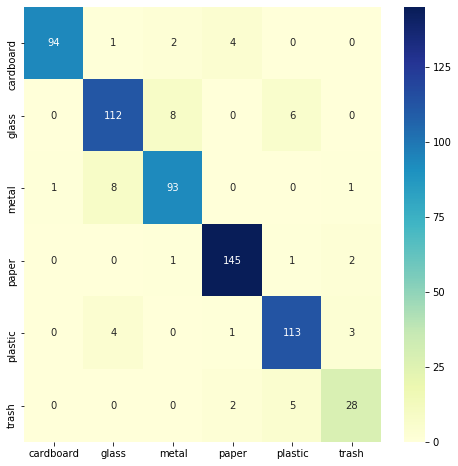

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, yhat)
print(cm)

import seaborn as sns
df_cm = pd.DataFrame(cm, waste_types, waste_types)

plt.figure(figsize=(8,8))
sns.heatmap(df_cm,annot=True, fmt="d", cmap="YlGnBu")

In [0]:
correct = 0

for i in range(len(yhat)) :
    if y[i] == yhat[i] :
        correct += 1

accuracy = correct / len(yhat)
accuracy

0.9212598425196851

In [0]:
# 리눅스 상에 저장된 폴더를 삭제함.
shutil.rmtree("data")
shutil.rmtree("dataset")

In [0]:
!ls

sample_data
